# Python в инженерных расчетах. Лекция 07.
<hr style="border:2px solid gray">

#### План занятия:

1. **Что такое SciPy?**
   - Обзор библиотеки и её основных модулей.
2. **Полезные методы SciPy с примерами из области испытания материалов.**
    - Аппроксимация кривой упрочнения моделью Свифта
    - Вычисление работы пластической деформации
    - Интерполяция истинных напряжений по деформации
    - Решение системы уравнений Аврами-Колмогорова

In [103]:
# Импортируем необходимые библиотеки
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, integrate, interpolate

# импортируем ранее разработанные классы для работы с данными
from Lection_006 import  Stress_strain

## 1. Что такое SciPy?

`SciPy` — это библиотека для научных и инженерных вычислений на языке Python. Она основана на `NumPy` и предоставляет широкий набор функций для:
- оптимизации и подбора параметров,
- численного интегрирования и дифференцирования,
- интерполяции и аппроксимации,
- обработки сигналов и изображений,
- статистики и линейной алгебры.

В этой лекции мы сосредоточимся на трёх ключевых задачах из области обработки металлов давлением:
1. Аппроксимация кривой упрочнения (моделью Свифта);
2. Вычисление работы пластической деформации;
3. Интерполяция истинных напряжений по деформации;
4. Решение системы уравнений Аврами-Колмогорова.

## 2. Примеры использования SciPy

In [104]:
# Загрузим экспериментальные данные сила и ход деформирования
steel_array = np.loadtxt('../data/load_stroke_data.txt', delimiter='\t', encoding='utf-8-sig')

# Геометрические параметры образца
steel_data = {'Le': 80 + steel_array[-1, 0], 'a0': 1.5, 'b0':20, 'L0': 80 }
# площадь поперечного сечения образца
A0 = steel_data['a0']*steel_data['b0']

# создадим объект класса Stress_strain
steel_stress_strain = Stress_strain (steel_array[:,0], steel_array[:,1], 
                                   steel_data['L0'], A0, Le=steel_data['Le'])

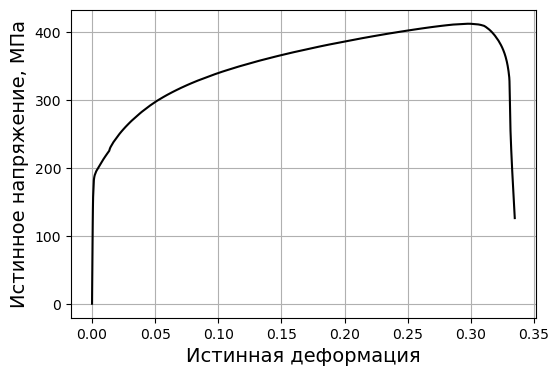

In [120]:
# посчитаем истиные напряжения и деформации
_ = steel_stress_strain.get_strain_true()
_ = steel_stress_strain.get_stress_true()

# и посмотрим на график
Stress_strain.plot_graph(steel_stress_strain.strain_true, steel_stress_strain.stress_true, 
                                 'Истинная деформация', 
                                 'Истинное напряжение, МПа')

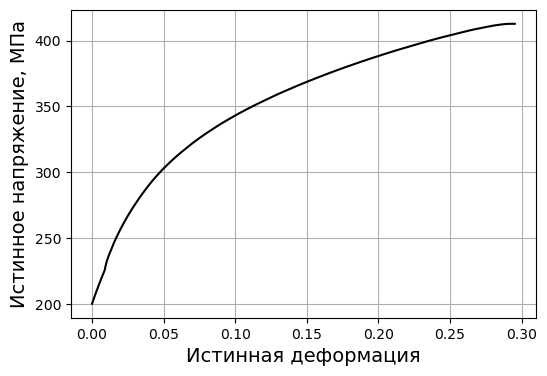

In [121]:
# выделим визуально кривую сопративления пласчитечкой деформации
flow_stress = Stress_strain.get_flow_curve(steel_stress_strain.strain_true, 
                                               steel_stress_strain.stress_true, 
                                               200., 0.3)
# здесь 200 МПа - напряжение ниже которого мы предполагаем деформацию упругой
# 0.3 - деформация выше которой начинает образовываться шейка

# посмотрим что получилось:
Stress_strain.plot_graph(flow_stress[:, 0], flow_stress[:, 1], 
                                 'Истинная деформация', 
                                 'Истинное напряжение, МПа')


### 2.1 Аппроксимация графика сопротивления пластической деформации моделью Свифта

Модель Свифта описывает зависимость истинного напряжения от истинной деформации:
$$
\sigma = K (\varepsilon_0 + \varepsilon)^n
$$
- $K$ — коэффициент прочности,
- $\varepsilon_0$ — начальная деформация,
- $n$ — показатель упрочнения.

In [107]:
# Определим функцию модели Свифта
def swift_model(eps, K, eps0, n):
    return K * (eps0 + eps) ** n

# определим вектор деформации и напряжения как отдельные переменные (для удобства)
strain_true = flow_stress[:, 0]
stress_true = flow_stress[:, 1]

# Начальные приближения параметров
p0_swift = [500, 0.0, 0.2]

# Аппроксимация
params_swift, _ = optimize.curve_fit(swift_model, strain_true, stress_true, p0=p0_swift)
K, eps0, n = params_swift

print(f'Модель Свифта: σ = {K:.1f}·(ε + {eps0:.4f})^{n:.3f}')

Модель Свифта: σ = 529.7·(ε + 0.0055)^0.196


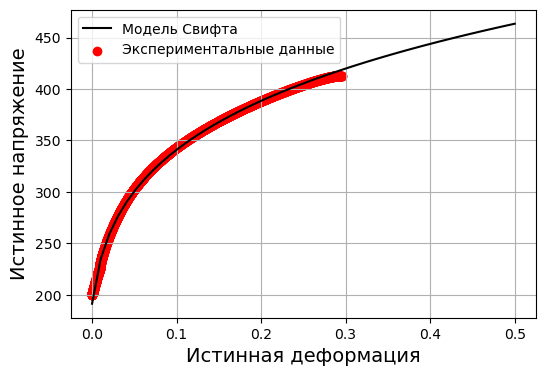

In [108]:
# сравним исходную кривую и модельную
strain_space = np.linspace(0, 0.5)
stress_swift = swift_model(strain_space, K, eps0, n)

plt.figure(figsize=(6, 4))
plt.plot (strain_space, stress_swift, '-', color = 'black', label = 'Модель Свифта')
plt.scatter (strain_true, stress_true, color = 'red', label = 'Экспериментальные данные')
# Добавляем названия осей
plt.xlabel ('Истинная деформация', fontsize = 14)
plt.ylabel ('Истинное напряжение', fontsize = 14)
# добавляем для красоты сетку
plt.grid()
# добавляем легенду
plt.legend()

# далее подобные графики будем вызывать из класса Stress_strain
# Stress_strain.plot_experiment_vs_model(data_exp, data_model, x_label, y_label)

### 2.2 Вычисление работы пластической деформации

Работа силы деформирования — это интеграл от силы по ходу:
$$
W = \int_0^{s_{\max}} F(s)\, ds
$$
Используем `scipy.integrate.quad` для численного интегрирования функции полученной интерполяцией данных (`scipy.interpolate.interp1d`).

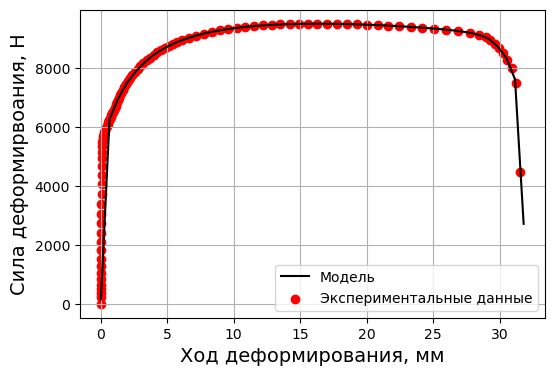

In [119]:
# Создадим интерполяционную функцию силы от хода
interp_load_stroke = interpolate.interp1d(steel_stress_strain.stroke, steel_stress_strain.load, 
                                kind='linear')

# Сравним графики интерполяции и график с машины
stroke_space = np.linspace (0, steel_stress_strain.stroke.max())
load_interp = interp_load_stroke (stroke_space)

# выведем результат
Stress_strain.plot_experiment_vs_model([steel_stress_strain.stroke[::50], steel_stress_strain.load[::50]],
                                            [stroke_space, load_interp],
                                            'Ход деформирования, мм', 'Сила деформирвоания, Н')

In [110]:
# Интегрируем от 0 до максимального хода
work, _ = integrate.quad(interp_load_stroke, 0, steel_stress_strain.stroke.max())

print(f'Работа пластической деформации: {work/1000:.1f} Дж')

Работа пластической деформации: 283.7 Дж


/tmp/ipykernel_105973/3528938124.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  work, _ = integrate.quad(interp_load_stroke, 0, steel_stress_strain.stroke.max())


In [111]:
# попробуем альтернативный метод интегрирования
work = integrate.simpson(load_interp, stroke_space)
print(f'Работа пластической деформации: {work/1000:.1f} Дж')

Работа пластической деформации: 283.0 Дж


### 2.3 Решение системы уравнений Аврами-Колмогорова

Уравнение Аврами описывает кинетику фазовых превращений:

$$
y(t) = 1 - \exp(-1/k \cdot (t - t_0)^n)
$$

Например, изотермическое превращение Аустенита в Перлит или Феррит или динамическая рекристаллизация при горячей пластической деформации.

где:
- $y(t)$ - доля превращения в момент времени $t$
- $t_0$ - время начала превращения
- $k$ - константа скорости превращения
- $n$ - показатель Аврами (характеризует механизм превращения)

Зная экспериментальные данные:
- $t_{start}$ - время начала превращения ($y = 0.01$)
- $t_{50}$ - время 50% превращения ($y = 0.5$)
- $t_{end}$ - время окончания превращения ($y = 0.99$)

Можем определить параметры $k$ и $n$.

In [112]:
# Функция Аврами
def avrami_equation(t, t0, k, n):
    """
    Уравнение Аврами для доли превращения
    
    """
    b = 1/k
    
    return 1 - np.exp(- b * (t - t0) ** n)

In [113]:
# Экспериментальные данные (пример для фазового превращения в стали)
t_start = 10.0  # время начала превращения, с
t_50 = 87.0     # время 50% превращения, с  
t_end = 195.0    # время окончания превращения, с

In [114]:
# Система уравнений для определения k и n
def system_equations(vars):

    k, n = vars

    # Уравнение для 50% превращения
    eq1 = avrami_equation (t_50, t_start, k, n) - 0.5
        
    # Уравнение для 99% превращения (принимаем за окончание)
    eq2 = avrami_equation (t_end, t_start, k, n) - 0.99
    
    return [eq1, eq2]

In [115]:
# Решение системы уравнений
initial_guess = [10.0, 1.0]  # начальное приближение для k и n

solution = optimize.fsolve(system_equations, initial_guess)

k, n = solution

print("Параметры уравнения Аврами:")
print(f"Константа скорости (k) = {k:.4f}")
print(f"Показатель Аврами (n) = {n:.2f}")

Параметры уравнения Аврами:
Константа скорости (k) = 17168.5713
Показатель Аврами (n) = 2.16


In [116]:
# попробуем альтернативный, более продвинутый метод
initial_guess = [10, 1.1]  # начальное приближение для k и n
bounds=([1.0, 1.1], [np.inf, 4]) # границы возможных значений k и n

solution = optimize.least_squares(system_equations, initial_guess, bounds=bounds)
k, n = solution.x

print("Параметры уравнения Аврами:")
print(f"Константа скорости (k) = {k:.4f}")
print(f"Показатель Аврами (n) = {n:.2f}")


Параметры уравнения Аврами:
Константа скорости (k) = 17168.5679
Показатель Аврами (n) = 2.16


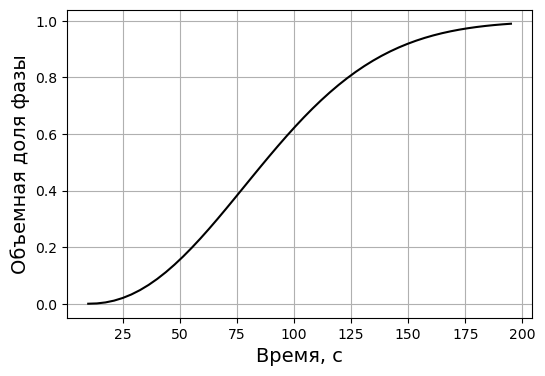

In [118]:
# визуализируем резальтат
# создадим массив значенией времени

time = np.linspace(t_start, t_end)
fraction = avrami_equation (time, t_start, k, n)
Stress_strain.plot_graph(time, fraction, 
                                 'Время, с', 
                                 'Объемная доля фазы')


## 3. Заключение
### Использованные в лекции методы SciPy

- **`scipy.optimize.curve_fit`** — аппроксимация экспериментальных данных моделью Свифта.  
- **`scipy.integrate.quad`** — численное интегрирование для вычисления работы пластической деформации.  
- **`scipy.interpolate.interp1d`** — линейная интерполяция зависимости силы от хода деформирования.  
- **`scipy.optimize.fsolve`** — решение системы нелинейных уравнений для определения параметров уравнения Аврами–Колмогорова.  
- **`scipy.optimize.least_squares`** — альтернативный метод подбора параметров уравнения Аврами с учётом ограничений.